# Logistic Regression


The problem is, we are trying to predict which DataSciencester users paid for premium accounts
As is typical with categorical variables, we represent the dependent variable as either 0(no premium account) or 1 (premium account)

In [9]:
 # data is list of rows [experience, salary, paid_account]

experience_and_salary = {
    0.7: 48000.0, 
    1.9: 48000.0, 
    2.5: 60000.0, 
    4.2: 63000.0, 
    6.0: 76000.0, 
    6.5: 69000.0,  
    7.5: 76000.0, 
    8.1: 88000.0, 
    8.7: 83000.0, 
    10.0: 83000.0
}

paid = """
0.7  paid 
1.9  unpaid 
2.5  paid 
4.2  unpaid 
6.0  unpaid 
6.5  unpaid 
7.5  unpaid 
8.1  unpaid 
8.7  paid 
10.0 paid
"""

# Convert paid -> dictionary
paid_map = {}
for line in paid.strip().split("\n"):
    exp, status = line.split()
    paid_map[float(exp)] = 1 if status == "paid" else 0

# Create dataset
data = []
for exp, salary in experience_and_salary.items():
    data.append([exp, salary, paid_map[exp]])

# data  = [exp, salary, paid_map]
xs = [[1.0] + row[:2] for row in data]                # [1, experience, salary]
ys = [row[2] for row in data]                        # paid_account

If we check the linear regression for this, the best model can we get:

`paid account = β0 + β1experience + β2salary + ε`

## Below code is from Ch4, Ch8, Ch10 and Ch15

In [10]:
from typing import List,Tuple
import math

Vector  = List[float]

def vector_sum(vectors: List[Vector])->Vector:
    assert vectors, "No Vectors"
    num_len = len(vectors[0])
    assert all(num_len == len(v) for v in vectors),"different sizes"
    return [sum(vector[i] for vector in vectors) for i in range(num_len)]
  
def standard_deviation(xs:List[float])-> float:
    ''' The standard deviation is the square root of the variance '''
    return math.sqrt(variance(xs))

def vector_mean(vectors: List[Vector])-> Vector:
    num_elements = len(vectors)
    return [(1/num_elements)*i for i in vector_sum(vectors)]

def variance(xs:List[float])->float:
    assert len(xs) >= 2 , "variance requires at least two elements"

    n = len(xs)
    deviations = de_mean(xs)
    return(sum_of_squares(deviations)/(n-1))

def mean(xs: List[float])-> float:
    return sum(xs)/len(xs)

def de_mean(xs:List[float]) -> List[float]:
    x_bar = mean(xs)
    return[x-x_bar for x in xs]

def sum_of_squares(xs:List[float])-> float:
    return sum(x_i*x_i for x_i in xs)


def scale(data: List[Vector]) -> Tuple[Vector, Vector]:
    """ Returns the mean and standard deviation for each position """
    dim = len(data[0])

    means  = vector_mean(data)
    stdevs  = [standard_deviation([vector[i] for vector in data])
               for i in range(dim)]
    return means,stdevs

def rescale(data: List[Vector]) -> List[Vector]:
    """
    Rescales the input data so that each position has mean 0 and standard deviaiton 1.
    (Leaves a position as is if its standard deviation is 0)
    """

    dim = len(data[0])
    means,stdevs = scale(data)

   # Make copy of each vector
    rescaled = [v[:] for v in data]

    for v in rescaled:
      for i in range(dim):
        if stdevs[i]>0:
            v[i]  = (v[i] - means[i])/stdevs[i]

    return rescaled

def scalar_multiplication(c:float, v:Vector)-> Vector:
    return[c*x for x in v]

def add(v:Vector, w:Vector)-> Vector:
    assert len(v)==len(w), "Vectors must be in same length"
    return[v_i+w_i for v_i,w_i in zip(v,w)]

def gradient_step(v:Vector, gradient:Vector, step_size: float) -> Vector:
    """ Moves 'step size' in the `gradient` direction from `v` """
    assert len(v) == len(gradient)
    step = scalar_multiplication(step_size, gradient)
    return add(v,step)


def error(x:Vector, y:float, beta:Vector)-> float:
    return predict(x,beta) - y

def squared_error(x:Vector, y:float, beta:Vector)-> float:
    return error(x,y,beta)**2

def sqerror_gradient(x:Vector,y:float,beta:Vector)->Vector:
    err = error(x,y,beta)
    return [2*err*x_i for x_i in x]

import random
import tqdm

def least_squares_fit(xs:List[Vector],
                      ys:List[float],
                      learning_rate: float = 0.001,
                      num_steps:int = 1000,
                      batch_size:int = 1) -> Vector:
    """
    Find the beta the minimizes the sum of squared errors
    assuming the model y = dot(x, beta)
    """

    # start with a random guess
    guess = [random.random() for _ in xs[0]]

    for _ in tqdm.trange(num_steps, desc="least_squares_fit"):
        for start in range (0,len(xs),batch_size):
            batch_xs = xs[start:start+batch_size]
            batch_ys = ys[start:start+batch_size]

            gradient = vector_mean([sqerror_gradient(x,y,guess)
                                   for x,y in zip(batch_xs,batch_ys)])
            guess = gradient_step(guess,gradient,-learning_rate)
    
    return guess

def dot(v:Vector,w:Vector)->Vector:
    assert len(v) == len(w), "different sizes"
    return sum(v_i * w_i for v_i,w_i in zip(v,w))

def predict(x:Vector, beta:Vector)->float:
    """ assumes that the first element of x is 1 """
    return dot(x,beta)


#### Implementing linear regression to predict premium accounts

least_squares_fit: 100%|██████████| 1000/1000 [00:00<00:00, 12248.32it/s]


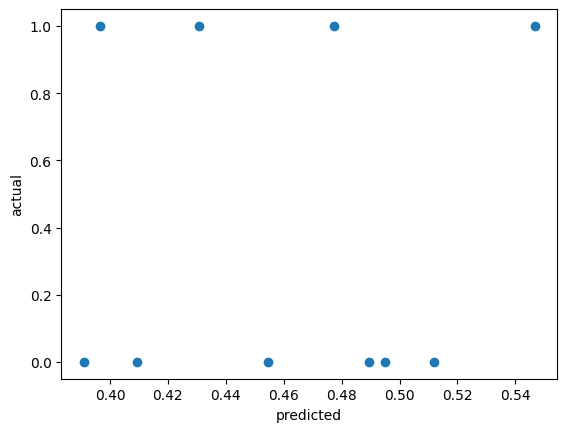

In [11]:
from matplotlib import pyplot as plt
 
learning_rate = 0.0001
rescaled_xs = rescale(xs)
beta = least_squares_fit(rescaled_xs,ys,learning_rate,1000,1)

predictions = [predict(x_i,beta) for x_i in rescaled_xs]

plt.scatter(predictions,ys)
plt.xlabel("predicted")
plt.ylabel("actual")
plt.show()


- Linear regression can predict numbers like -2 or 5, but probabilities must be between 0 and 1.

- Large feature values (like more experience) make predictions too big → model becomes wrong/bias.

- We want big positive values → probability near 1 and big negative values → probability near 0.

Solution: Use the sigmoid function, which converts any number into a value between 0 and 1.

## The Logistic Function

In [15]:
def logistic(x:float)->float:
    return 1.0 / (1+math.exp(-x))

In [16]:
# It's derivative 
def logistic_prime(x:float)->float:
    y = logistic(x)
    return y * (1 - y)

We will use this to fit a model

`yi = f(xiβ) + εi`

here, 
- f is the logistic(sigmoid) function

- xiβ = linear combination of inputs


## Logistic Regression — Likelihood Explanation

### Why not squared error?
In logistic regression, minimizing squared error is **not equivalent** to maximizing likelihood.  
So instead, we directly maximize the likelihood using **gradient descent**.

---

## Model Assumption

Given some **β (beta)**:

- Probability that `yi = 1` → `f(xiβ)`
- Probability that `yi = 0` → `1 − f(xiβ)`

Where **f** is the **logistic (sigmoid) function**.

---

## Probability Formula (PDF)

The probability of observing `yi` is:



`p(yi | xi, β) = f(xiβ)^yi * (1 − f(xiβ))^(1−yi)`


### Why this works:

- If `yi = 1`  
  → `f(xiβ)^1 * (1-f(xiβ))^0 = f(xiβ)`

- If `yi = 0`  
  → `f(xiβ)^0 * (1-f(xiβ))^1 = 1 − f(xiβ)`

So one formula handles both cases.

---

## Log-Likelihood (Easier to Optimize)

Instead of multiplying many probabilities, we take the log:

`log L(β | xi, yi) = yi * log(f(xiβ)) + (1 − yi) * log(1 − f(xiβ))`


Because log is strictly increasing function, any beta that maximizes tha log likelihood also maximizes the likelihood and vice versa.


Because gradient descent minimizes things, we'll actually work with the negative log likelihood, since maximizing the likelihood is same as minimizing its negative

In [12]:
import math
from typing import List

Vector = List[float]

def dot(v:Vector, w:Vector)->Vector:
    assert len(v) == len(w), "different sizes"
    return sum(v_i*w_i for v_i,w_i in zip(v,w))

def _negative_log_likelihood(x:Vector,y:float,beta:Vector)-> float:
    """ The negative log likelihood for one data point """
    if y == 1:
        return -math.log(logistic(dot(x,beta)))
    else:
        return -math.log(1-logistic(dot(x,beta)))

In [13]:
from typing import List
def negative_log_likelihood(xs:List[Vector],
                            ys:List[Vector],
                            beta:Vector) -> float:
    return sum(_negative_log_likelihood(x,y,beta) for x,y in zip(xs,ys))



# Using calculus for the gradient

def _negative_log_partial_j(x:Vector, y:float, beta:Vector,j:int) -> float:
    """ The jth partial derivative for one data point.
    Here i is the index of the data point"""

    return -(y-logistic(dot(x,beta))) * x[j]

def _negative_log_gradient(x:Vector, y:float, beta:Vector) -> Vector:
    """ The gradient for one data point """
    return [_negative_log_partial_j(x,y,beta,j) for j in range(len(beta))]

def negative_log_gradient(xs:List[Vector],
                          ys: List[float],
                          beta:Vector)-> Vector:
    return vector_sum([_negative_log_gradient(x,y,beta) for x,y in zip(xs,ys)])


#### Applying The Model

In [17]:
import random
import tqdm 
from typing import TypeVar,List,Tuple

X = TypeVar('X')     # generic to represent a data point
def split_data(data:List[X],prob:float)-> Tuple[List[X],List[X]]:
    """ Split data into fractions [prob, 1-prob] """
    data = data[:]     # Shallow copy
    random.shuffle(data)        # Shuffle modifies the list
    cut = int(len(data)*prob)        # use prob to find a cutoff
    return data[:cut], data[cut:]
 
Y = TypeVar('V')                   # generic type to represent output variable
def train_test_split(xs:List[X],
                     ys: List[Y],
                     test_pct: float) -> Tuple[List[X], List[X], List[Y], List[Y]]:
    # Generate the indices and split them
    idxs = [i for i in range(len(xs))]
    train_idxs, test_idxs = split_data(idxs, 1 - test_pct)
    return ([xs[i] for i in train_idxs],   # x_train
            [xs[i] for i in test_idxs],     # x_test
            [ys[i] for i in train_idxs],    # y_train
            [ys[i] for i in test_idxs])      # y_test

random.seed(0)
x_train, x_test, y_train, y_test = train_test_split(rescaled_xs, ys, 0.33) 
 
learning_rate = 0.01 
 
# pick a random starting point
beta = [random.random() for _ in range(3)] 
 
with tqdm.trange(5000) as t: 
    for epoch in t: 
        gradient = negative_log_gradient(x_train, y_train, beta) 
        beta = gradient_step(beta, gradient, -learning_rate) 
        loss = negative_log_likelihood(x_train, y_train, beta) 
        t.set_description(f"loss: {loss:.3f} beta: {beta}")

loss: 0.732 beta: [-4.606080309068325, 7.16031907956837, -1.677171219448851]: 100%|██████████| 5000/5000 [00:07<00:00, 675.26it/s]       


## Goodness of Fit

In [18]:
true_positives = false_positives = true_negatives = false_negatives = 0

for x_i, y_i in zip(x_test, y_test):
    prediction = logistic(dot(beta, x_i))

    if y_i == 1 and prediction >= 0.5:
        true_positives += 1                # TP: paid and we predict paid
    elif y_i == 1:
        false_negatives += 1               # FN: paid and we predict unpaid
    elif prediction >= 0.5:
        false_positives += 1               # FP: unpaid and we predict paid
    else:
        true_negatives += 1                # TN: unpaid and we predict unpaid
 

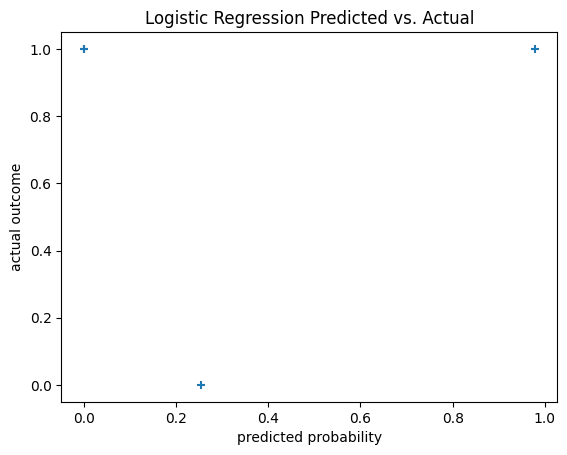

In [19]:
predictions = [logistic(dot(beta, x_i)) 
for x_i in x_test]
plt.scatter(predictions, y_test, marker='+')
plt.xlabel("predicted probability")
plt.ylabel("actual outcome")
plt.title("Logistic Regression Predicted vs. Actual")
plt.show()

# Support Vector Machines (SVM)

## 1. Decision Boundary
In a linear model like logistic regression, we define a boundary (hyperplane) using:

`dot(β, x_i) = 0`


This boundary separates the classes:
- Above the line → “paid”
- Below the line → “unpaid”

We can plot this hyperplane to see exactly how our model is separating the classes.

---

## 2. Hyperplane
- A **hyperplane** is the boundary that separates classes in feature space.
- It splits the **parameter space** into two halves corresponding to the two classes.
- Logistic regression finds this hyperplane indirectly by maximizing likelihood.

---

## 3. SVM Approach
- Instead of modeling probabilities, SVM directly finds the hyperplane that **best separates the classes**.
- SVM **maximizes the margin**, which is the distance between the hyperplane and the nearest points of each class.
- The nearest points are called **support vectors**, and they "support" the hyperplane.

**Key Idea:**  
SVM = hyperplane + maximum margin

---

## 4. Handling Non-Linearly Separable Data

### Problem: No Linear Hyperplane
- Sometimes, there is **no straight line (or hyperplane)** that perfectly separates the classes.
- Example: Overlapping data points in a “who pays?” dataset.

### Solution: Map to Higher Dimensions
- Transform the data into a **higher-dimensional space** where it becomes separable.
- Example: 1D data → map each point `x` to `(x, x^2)` in 2D.  
- Suddenly, a linear hyperplane can separate the classes in this 2D space.

### Kernel Trick
- Computing the high-dimensional mapping explicitly can be expensive.
- SVM uses a **kernel function** to compute dot products in the higher-dimensional space **without explicitly transforming the points**.
- This allows SVM to efficiently find hyperplanes in high-dimensional spaces.

**Common kernels:**
- Polynomial  
- RBF (Gaussian)  
- Sigmoid  

---

## 5. Practical Note
- SVM optimization is mathematically advanced and typically requires specialized software.
- For beginners, understanding the **concepts** is sufficient:
  - Linear SVM → separates classes with a straight hyperplane
  - Non-linear SVM → uses kernels to handle complex data

---

## Summary
- **Linear SVM**: finds a hyperplane that separates classes in the original space.  
- **Non-linear SVM**: maps data to a higher-dimensional space using kernels to find a separating hyperplane.
